In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999

In [22]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import r2_score
%matplotlib inline

In [3]:
train = pd.read_csv("mertrain.csv")
test = pd.read_csv("mertest.csv")

# process columns, apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [16]:
y = train['y'].values
y_mean = np.mean(y)
id_test = test['ID'].values
X = train.drop(['y','ID'], axis=1).values
X_test= test.drop(['ID'], axis=1).values

In [4]:
X = train.drop(['y'], axis=1).values

In [5]:
num_columns=X.shape[1]
num_columns

377

In [6]:
vifs=[variance_inflation_factor(X, i) for i in range(0, num_columns)]

C:\Users\chino\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\chino\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [7]:
from pandas import DataFrame
vif_df=DataFrame(vifs, index=train.drop(['y'], axis=1).columns, columns=['VIF'])
vif_df=vif_df.replace([np.inf, -np.inf], np.nan).dropna(how='all')
vif_df=vif_df.sort_values(ascending=False, by='VIF')


In [8]:
best_vif=[]
for i in list(vif_df.values):
    if i>=10:
        best_vif.append(i)

In [9]:
len(best_vif)

37

In [10]:
sig_vals=np.array(vif_df.index)
sig_vals

array(['X178', 'X362', 'X331', 'X49', 'X238', 'X129', 'X352', 'X179',
       'X215', 'X161', 'X103', 'X329', 'X328', 'X356', 'X246', 'X85',
       'X45', 'X367', 'X321', 'X256', 'X191', 'X358', 'X343', 'X355',
       'X150', 'X43', 'X312', 'X272', 'X2', 'X219', 'X57', 'X241', 'X234',
       'X197', 'X159', 'X65', 'X349', 'X223', 'X325', 'X87', 'X224',
       'X182', 'X100', 'X1', 'X114', 'X135', 'X357', 'X275', 'X294',
       'X361', 'X287', 'X148', 'X221', 'X327', 'X300', 'X350', 'X211',
       'X75', 'X78', 'X116', 'X69', 'X27', 'X47', 'X274', 'X81', 'X273',
       'X267', 'X351', 'X163', 'X70', 'X218', 'X68', 'X220', 'X50', 'X322',
       'X354', 'X3', 'X366', 'X51', 'X55', 'X0', 'X64', 'X210', 'X46',
       'X106', 'ID', 'X56', 'X82', 'X318', 'X5', 'X252', 'X153', 'X359',
       'X225', 'X384', 'X301', 'X212', 'X323', 'X79', 'X91', 'X231',
       'X206', 'X353', 'X151', 'X383', 'X141', 'X73', 'X38', 'X192',
       'X124', 'X6', 'X292', 'X8', 'X270', 'X291', 'X319', 'X104', 'X288',


In [11]:
vif_df.head()

,VIF
X178,1139.903769
X362,697.916906
X331,308.303315
X49,304.506282
X238,303.421330


In [12]:
vif_df_best=vif_df[vif_df.VIF>=10]
vif_best_index=vif_df_best.index

In [23]:
# pipelineでVIFで削除する特徴量の数のベストを探す。
r2_train=[]
r2_valid=[]
for i in np.arange(37):
    eliminate = vif_best_index[0:i]
    train_vif=train.drop(eliminate, axis=1)
    test_vif=test.drop(eliminate, axis=1)
    
    X = train_vif.drop(['y'], axis=1).values
    X_test= test_vif.values
    
    kf=KFold(n_splits=10, shuffle=True, random_state=0)
    kf.get_n_splits(X)
    
    for train_index, test_index in kf.split(X):
        X_train, y_train=X[train_index], y[train_index]
        X_valid, y_valid=X[test_index], y[test_index]

    # prepare dict of params for xgboost to run with
    #xgb_params = {
    #    'n_trees': 500, 
    #    'eta': 0.005,
    #    'max_depth': 4,
    #    'subsample': 0.95,
    #    'objective': 'reg:linear',
    #    'eval_metric': 'rmse',
    #    'base_score': y_mean, # base prediction = mean(target)
    #    'silent': 1
    #}
    xgb_params={
    'gamma': 1.0,
    'eta': 0.01,
    'max_depth': 3,
    'subsample':1.0,
    'objective' : 'reg:linear',
    'eval_metric': 'rmse',
    'base_score' : y_mean,
    'silent': 1,
    'lambda': 1,
    'alpha' : 0,
    'n_trees': 500
    }
# form DMatrices for Xgboost training
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid=xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)

# xgboost, cross-validation
    cv_result = xgb.cv(xgb_params, 
                       dtrain, 
                       num_boost_round=500, # increase to have better results (~700)
                       early_stopping_rounds=50,
                       verbose_eval=50, 
                       show_stdv=False
                      )

    num_boost_rounds = len(cv_result)
    print(num_boost_rounds)

# train model
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
    
    r2_train.append(r2_score(y_train, model.predict(dtrain)))
    r2_valid.append(r2_score(y_valid, model.predict(dvalid)))

[0]	train-rmse:12.5797	test-rmse:12.5798
[50]	train-rmse:10.0884	test-rmse:10.133
[100]	train-rmse:8.98398	test-rmse:9.06203
[150]	train-rmse:8.52534	test-rmse:8.63041
[200]	train-rmse:8.31975	test-rmse:8.46428
[250]	train-rmse:8.20659	test-rmse:8.39844
[300]	train-rmse:8.13182	test-rmse:8.37669
[350]	train-rmse:8.07437	test-rmse:8.37341
338
[0]	train-rmse:12.5797	test-rmse:12.5798
[50]	train-rmse:10.0884	test-rmse:10.133
[100]	train-rmse:8.98398	test-rmse:9.06203
[150]	train-rmse:8.52534	test-rmse:8.63041
[200]	train-rmse:8.31975	test-rmse:8.46428
[250]	train-rmse:8.20659	test-rmse:8.39844
[300]	train-rmse:8.13182	test-rmse:8.37669
[350]	train-rmse:8.07437	test-rmse:8.37341
338
[0]	train-rmse:12.5797	test-rmse:12.5798
[50]	train-rmse:10.0884	test-rmse:10.133
[100]	train-rmse:8.98398	test-rmse:9.06203
[150]	train-rmse:8.52534	test-rmse:8.63041
[200]	train-rmse:8.31975	test-rmse:8.46428
[250]	train-rmse:8.20659	test-rmse:8.39844
[300]	train-rmse:8.13182	test-rmse:8.37669
[350]	train-rms

[350]	train-rmse:8.07492	test-rmse:8.37197
340
[0]	train-rmse:12.5797	test-rmse:12.5798
[50]	train-rmse:10.0884	test-rmse:10.133
[100]	train-rmse:8.98398	test-rmse:9.06203
[150]	train-rmse:8.52534	test-rmse:8.63041
[200]	train-rmse:8.31976	test-rmse:8.46418
[250]	train-rmse:8.20675	test-rmse:8.39805
[300]	train-rmse:8.13244	test-rmse:8.37514
[350]	train-rmse:8.07493	test-rmse:8.37195
340
[0]	train-rmse:12.5797	test-rmse:12.5798
[50]	train-rmse:10.0884	test-rmse:10.133
[100]	train-rmse:8.98398	test-rmse:9.06203
[150]	train-rmse:8.52534	test-rmse:8.63041
[200]	train-rmse:8.31976	test-rmse:8.46418
[250]	train-rmse:8.20675	test-rmse:8.39805
[300]	train-rmse:8.13244	test-rmse:8.37514
[350]	train-rmse:8.07493	test-rmse:8.37195
340
[0]	train-rmse:12.5797	test-rmse:12.5798
[50]	train-rmse:10.0884	test-rmse:10.133
[100]	train-rmse:8.98399	test-rmse:9.06199
[150]	train-rmse:8.5254	test-rmse:8.6303
[200]	train-rmse:8.31997	test-rmse:8.46359
[250]	train-rmse:8.20706	test-rmse:8.3962
[300]	train-rm

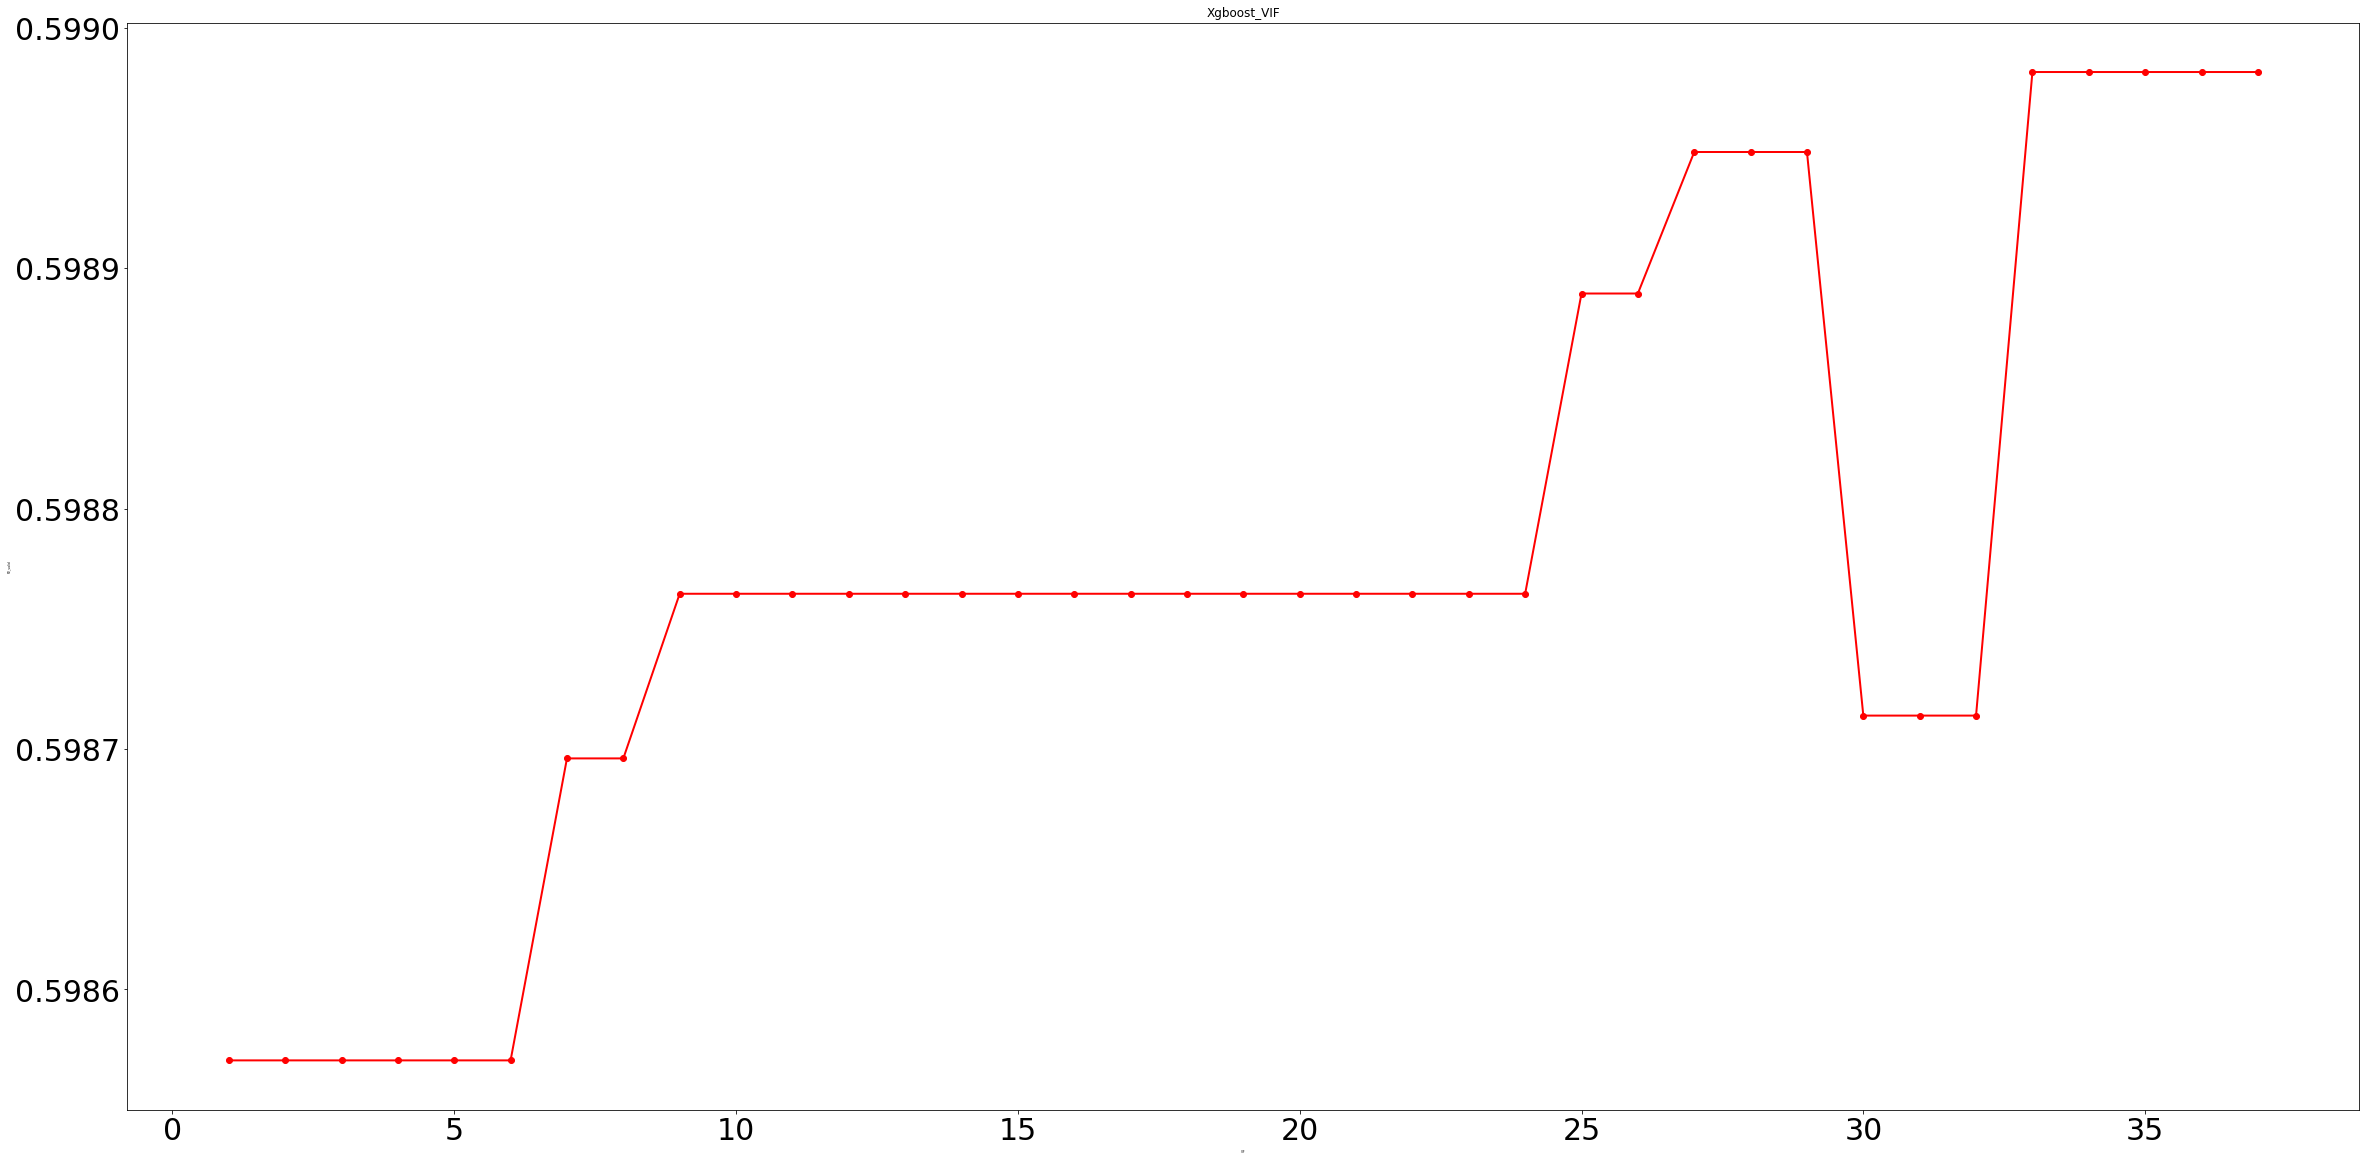

In [24]:
ig = plt.figure(figsize=(40,20))
sing_vals = np.arange(len(r2_valid) )+1
plt.plot(sing_vals, r2_valid, 'ro-', linewidth=2)
plt.title('Xgboost_VIF')
plt.xlabel('VIF',fontsize=3)
plt.ylabel('R2_valid',fontsize=3)
plt.tick_params(labelsize=30)

plt.show()

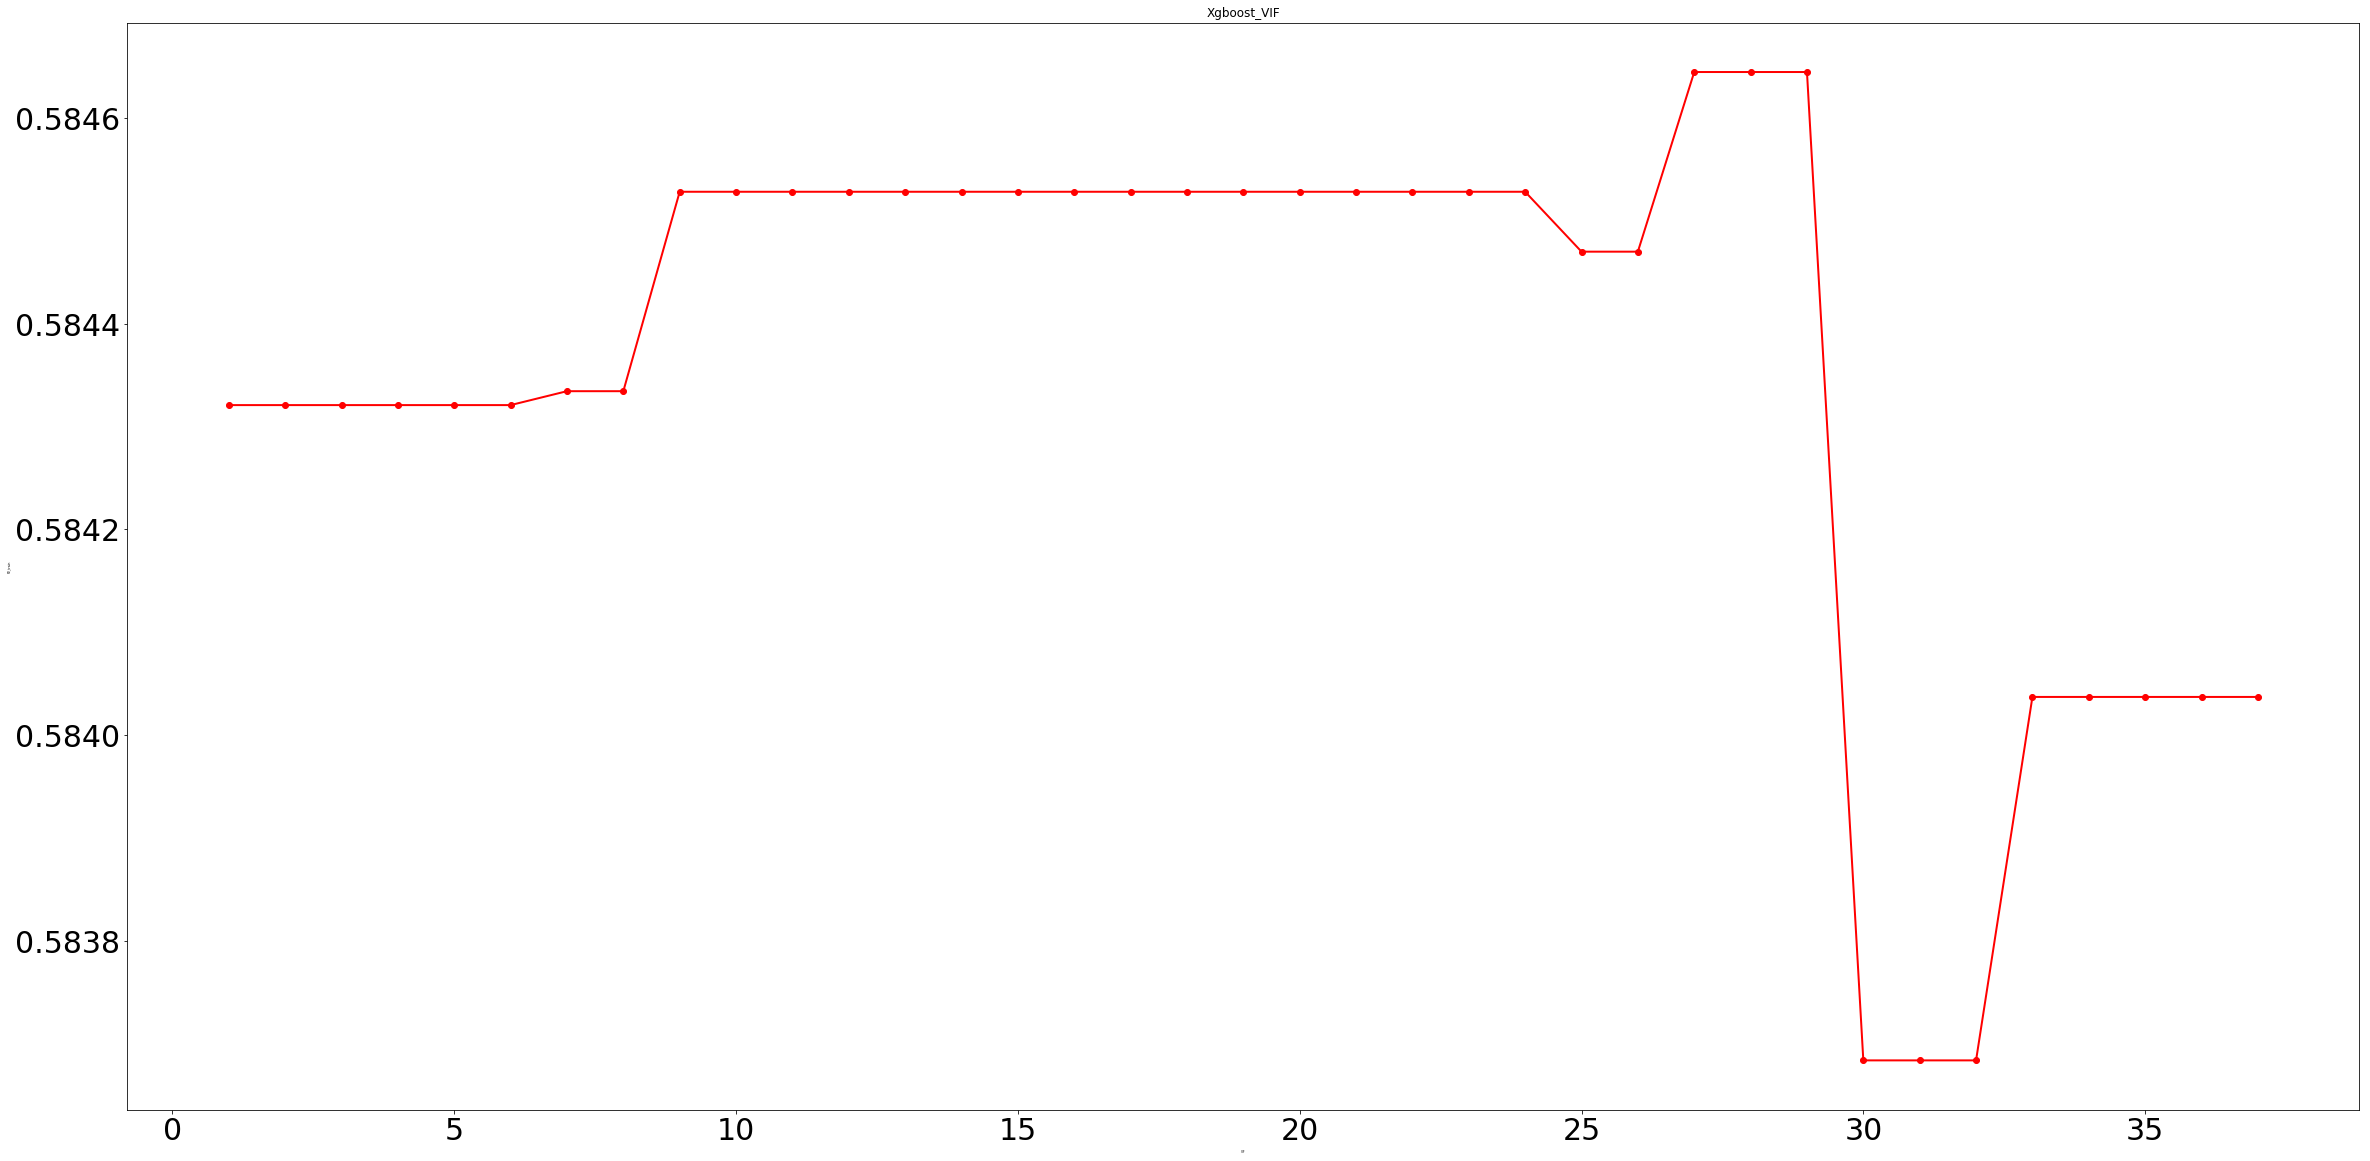

In [25]:
ig = plt.figure(figsize=(40,20))
sing_vals = np.arange(len(r2_train) )+1
plt.plot(sing_vals, r2_train, 'ro-', linewidth=2)
plt.title('Xgboost_VIF')
plt.xlabel('VIF',fontsize=3)
plt.ylabel('R2_train',fontsize=3)
plt.tick_params(labelsize=30)

plt.show()

In [51]:
train_vif=train.drop(vif_best_index[0:27], axis=1)
test_vif=test.drop(vif_best_index[0:27], axis=1)

In [52]:
y = train_vif['y'].values
y_mean = np.mean(y)
id_test = test_vif['ID'].values
X = train_vif.drop(['y'], axis=1).values
X_test= test_vif.values

In [53]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=10, shuffle=True, random_state=0)
kf.get_n_splits(X)

10

In [54]:
for train_index, test_index in kf.split(X):
    X_train, y_train=X[train_index], y[train_index]
    X_valid, y_valid=X[test_index], y[test_index]

In [55]:
import xgboost as xgb

# prepare dict of params for xgboost to run with
#xgb_params = {
#        'n_trees': 500, 
#        'eta': 0.005,
#        'max_depth': 4,
#        'subsample': 0.95,
#        'objective': 'reg:linear',
#        'eval_metric': 'rmse',
#        'base_score': y_mean, # base prediction = mean(target)
#        'silent': 1
#    }

xgb_params={
    'gamma': 1.0,
    'eta': 0.01,
    'max_depth': 3,
    'subsample':1.0,
    'objective' : 'reg:linear',
    'eval_metric': 'rmse',
    'base_score' : y_mean,
    'silent': 1,
    'lambda': 1,
    'alpha' : 0,
    'n_trees': 500
   }

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(X_train, y_train)
dvalid=xgb.DMatrix(X_valid, y_valid)
dtest = xgb.DMatrix(X_test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.5797	test-rmse:12.5798
[50]	train-rmse:10.0884	test-rmse:10.133
[100]	train-rmse:8.98399	test-rmse:9.06199
[150]	train-rmse:8.5254	test-rmse:8.6303
[200]	train-rmse:8.31997	test-rmse:8.46359
[250]	train-rmse:8.20706	test-rmse:8.3962
[300]	train-rmse:8.13271	test-rmse:8.37378
[350]	train-rmse:8.07539	test-rmse:8.36996
342


In [56]:
from sklearn.metrics import r2_score

# now fixed, correct calculation
print(r2_score(y_train, model.predict(dtrain)))
print(r2_score(y_valid, model.predict(dvalid)))

0.584644346267
0.598948277794


In [57]:
y_pred = model.predict(dtest)

In [58]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred
sub.to_csv('xgboost-bestparam_vif27.csv', index=False)
